# Benchmark

## Benchmark for NeighborSearch in mdapy and [freud](https://github.com/glotzerlab/freud).

In [1]:
import mdapy as mp
import freud
import numpy as np
from time import time
import matplotlib.pyplot as plt
from mdapy import pltset, cm2inch
mp.init()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.0
[Taichi] Starting on arch=x64


In [2]:
mp.__version__

'0.9.5'

In [3]:
def test_neighbor_average_time(ave_num=3, check=False):
    time_list = []
    print("*" * 30)
    for num in [5, 25, 45, 65, 85, 105, 125]:
        FCC = mp.LatticeMaker(3.615, "FCC", num, 100, 100)
        FCC.compute()
        print(f"Build {FCC.N} atoms...")
        freud_t, mdapy_t = 0.0, 0.0
        for turn in range(ave_num):
            print(f"Running {turn+1} turn in freud...")
            box = freud.box.Box(Lx=FCC.box[0, 0], Ly=FCC.box[1, 1], Lz=FCC.box[2, 2])

            shift_pos = (
                FCC.pos
                - np.min(FCC.pos, axis=0)
                - np.array([np.linalg.norm(FCC.box[i]) for i in range(3)]) / 2
            )
            start = time()
            aq = freud.locality.AABBQuery(box, shift_pos)
            nlist = aq.query(
                shift_pos, {"r_max": 5.0, "exclude_ii": True}
            ).toNeighborList()
            end = time()
            freud_t += end - start

            print(f"Running {turn+1} turn in mdapy...")
            start = time()
            neigh = mp.Neighbor(FCC.pos, FCC.box, 5.0, max_neigh=50)
            neigh.compute()
            end = time()
            mdapy_t += end - start
            if check:
                print(f"Checking results of {turn} turn...")
                assert (nlist.neighbor_counts == neigh.neighbor_number).all()
        time_list.append([FCC.N, freud_t / ave_num, mdapy_t / ave_num])
        print("*" * 30)
    time_list = np.array(time_list)
    return time_list

In [4]:
time_list = test_neighbor_average_time(ave_num=1) # For simple output only run one turn.

******************************
Build 200000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 1000000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 1800000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 2600000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 3400000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 4200000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************
Build 5000000 atoms...
Running 1 turn in freud...
Running 1 turn in mdapy...
******************************


Text(0, 0.5, 'Time (s)')

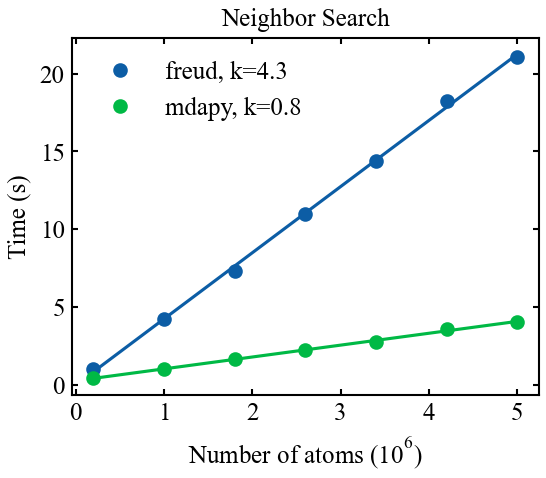

In [5]:
pltset()
colorlist = [i["color"] for i in list(plt.rcParams["axes.prop_cycle"])]
fig = plt.figure(figsize=(cm2inch(10), cm2inch(8)), dpi=150)
plt.subplots_adjust(left=0.16, bottom=0.165, top=0.92, right=0.95)
N_max = time_list[-1, 0]
exp_max = int(np.log10(N_max))
x, y = time_list[:, 0] / 10**exp_max, time_list[:, 1]

popt = np.polyfit(x, y, 1)
plt.plot(x, np.poly1d(popt)(x), c=colorlist[0])
plt.plot(x, y, "o", label=f"freud, k={popt[0]:.1f}")

y1 = time_list[:, 2]
popt = np.polyfit(x, y1, 1)
plt.plot(x, np.poly1d(popt)(x), c=colorlist[1])
plt.plot(x, y1, "o", label=f"mdapy, k={popt[0]:.1f}")
plt.title('Neighbor Search', fontsize=12)
plt.legend()
plt.xlabel("Number of atoms ($\mathregular{10^%d}$)" % exp_max)
plt.ylabel("Time (s)")